In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, linestring
from pathlib import Path
import os
from PIL import Image

import torch
from torchvision import models
import torchvision.transforms as transforms
from torchvision.models import VGG16_Weights

In [21]:
data_path = Path('London_UK')

# Load data
panoids = gpd.read_file(data_path / 'panoids/panoids.geojson')
network = gpd.read_file(data_path / 'network/edges/edges.geojson')

image_data = {
    'image_id': np.arange(len(panoids)),
    'panoid': panoids['panoid'],
    'longitude': panoids['lng'],
    'latitude': panoids['lat'],
}
images_df = pd.DataFrame(image_data)

streets = network

# Create GeoDataFrame for Images
geometry = [Point(xy) for xy in zip(images_df['longitude'], images_df['latitude'])]
images_gdf = gpd.GeoDataFrame(images_df, geometry=geometry, crs=network.crs)


In [ ]:
def split_line(line, max_segment_length=50):
    # Calculate the number of segments
    num_segments = int(line.length // max_segment_length) + 1
    segment_length = line.length / num_segments
    
    # Create a list to store the segments
    segments = []
    
    # Generate points along the line at each segment length
    for i in range(num_segments):
        start_point = line.interpolate(i * segment_length)
        end_point = line.interpolate(min((i + 1) * segment_length, line.length))
        segment = LineString([start_point, end_point])
        segments.append(segment)
    
    return segments

# Load the streets data
streets = gpd.read_file('London_UK/network/edges/edges.geojson')

# Re-project to a suitable CRS if necessary
if streets.crs.is_geographic:
    streets = streets.to_crs(epsg=28992)  # Use a projected CRS like EPSG:28992 for the Netherlands

# Calculate lengths
streets['length'] = streets.length

# Split lines longer than 100 meters
split_segments = []
for _, row in streets.iterrows():
    if row['length'] > 100:
        split_segments.extend(split_line(row['geometry'], max_segment_length=50))
    else:
        split_segments.append(row['geometry'])

# Create a new GeoDataFrame with the split segments
split_streets_gdf_max = gpd.GeoDataFrame(geometry=split_segments, crs=streets.crs)

# Optionally, calculate the new lengths
split_streets_gdf_max_L = split_streets_gdf_max.length

split_streets_gdf_max['length'] = split_streets_gdf_max_L


# Display the result
print(split_streets_gdf_max)


                                               geometry     length
0     LINESTRING (-224559.45 405323.931, -224588.869...  32.202141
1     LINESTRING (-224588.869 405310.835, -224632.67...  45.345370
2     LINESTRING (-224632.678 405322.537, -224676.53...  45.345382
3     LINESTRING (-224713.082 405344.849, -224676.53...  38.105447
4     LINESTRING (-224713.082 405344.849, -224736.85...  27.635476
...                                                 ...        ...
5807  LINESTRING (-224265.34 406775.406, -224232.712...  33.118631
5808  LINESTRING (-224232.712 406769.725, -224197.67...  37.884646
5809  LINESTRING (-224197.674 406755.318, -224161.70...  37.805940
5810  LINESTRING (-224250.452 406784.135, -224247.72...   3.009515
5811  LINESTRING (-224247.727 406782.858, -224182.29...  94.399716

[5812 rows x 2 columns]


In [6]:
import geopandas as gpd
from shapely.geometry import LineString
from shapely.ops import linemerge

def merge_short_lines(streets_gdf, min_total_length=50, max_individual_length=10):
    merged_segments = []
    current_merge = []

    for _, row in streets_gdf.iterrows():
        line = row['geometry']
        line_length = line.length

        if line_length < max_individual_length:
            current_merge.append(line)
            total_length = sum([seg.length for seg in current_merge])

            if total_length >= min_total_length:
                merged_line = linemerge(current_merge)
                merged_segments.append(merged_line)
                current_merge = []
        else:
            if current_merge:
                merged_line = linemerge(current_merge)
                merged_segments.append(merged_line)
                current_merge = []
            merged_segments.append(line)

    # If there are any remaining lines in the current merge, add them
    if current_merge:
        merged_line = linemerge(current_merge)
        merged_segments.append(merged_line)

    return gpd.GeoDataFrame(geometry=merged_segments, crs=streets_gdf.crs)



# Merge short lines
merged_streets_gdf = merge_short_lines(split_streets_gdf_max)

# Optionally, calculate the new lengths
merged_streets_gdf['length'] = merged_streets_gdf.length

merged_streets_gdf


,geometry,length
0,"LINESTRING (-224559.45 405323.931, -224588.869...",32.202141
1,"LINESTRING (-224588.869 405310.835, -224632.67...",45.345370
2,"LINESTRING (-224632.678 405322.537, -224676.53...",45.345382
3,"LINESTRING (-224713.082 405344.849, -224676.53...",38.105447
4,"LINESTRING (-224713.082 405344.849, -224736.85...",27.635476
...,...,...
5029,"LINESTRING (-224265.34 406775.406, -224232.712...",33.118631
5030,"LINESTRING (-224232.712 406769.725, -224197.67...",37.884646
5031,"LINESTRING (-224197.674 406755.318, -224161.70...",37.805940
5032,"LINESTRING (-224250.452 406784.135, -224247.72...",3.009515


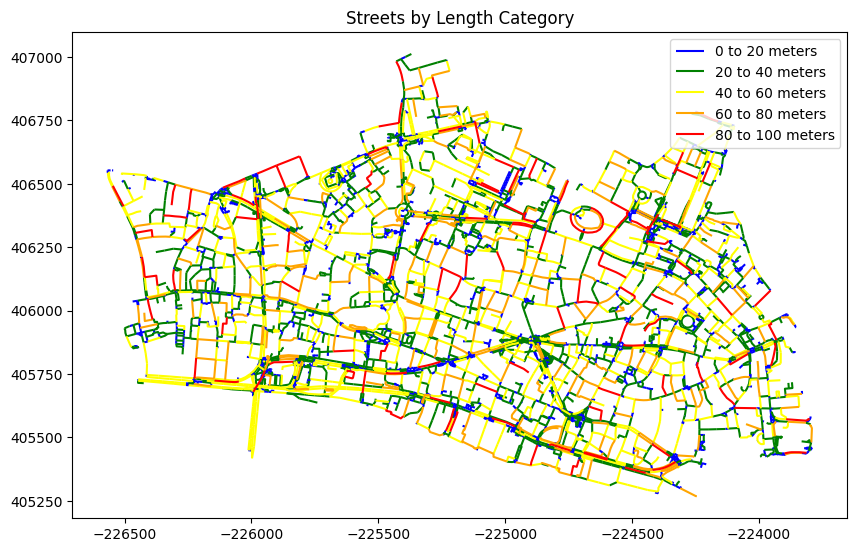

In [7]:
# Define a function to categorize lengths and assign colors
def categorize_and_plot(gdf):
    # Define the bins and corresponding colors
    bins = [0, 20, 40, 60, 80, 100]
    colors = ['blue', 'green', 'yellow', 'orange', 'red']
    
    # Create a new column 'category' based on the length
    gdf['category'] = np.digitize(gdf['length'], bins, right=True)
    
    # Plot each category with a different color
    fig, ax = plt.subplots(figsize=(10, 10))
    for i, color in enumerate(colors, start=1):
        category_gdf = gdf[gdf['category'] == i]
        if not category_gdf.empty:
            category_gdf.plot(ax=ax, color=color, label=f'{bins[i-1]} to {bins[i]} meters')
    
    plt.title('Streets by Length Category')
    plt.legend()
    plt.show()



# Call the function to categorize and plot
categorize_and_plot(merged_streets_gdf)

In [24]:
import geopandas as gpd
from shapely.geometry import Point, MultiPoint

# Load the streets data if not already loaded
streets = gpd.read_file('London_UK/network/edges/edges.geojson')

# Create a list to store intersection points
intersection_points = []

# Iterate over each pair of LineStrings to find intersections
for i, line1 in enumerate(streets['geometry'][:200]):
    for j, line2 in enumerate(streets['geometry'][:200]):
        if i >= j:  # Avoid duplicate checks and self-intersection
            continue
        if line1.intersects(line2):
            intersection = line1.intersection(line2)
            if intersection.geom_type == 'Point':
                intersection_points.append(intersection)
            elif intersection.geom_type == 'MultiPoint':
                intersection_points.extend(intersection.geoms)

# Create a GeoDataFrame for the intersection points
intersection_gdf = gpd.GeoDataFrame(geometry=intersection_points, crs=streets.crs)

# Display the first few rows of the GeoDataFrame
print(intersection_gdf.head())

                    geometry
0  POINT (-0.08535 51.50862)
1  POINT (-0.08535 51.50862)
2  POINT (-0.08366 51.50861)
3   POINT (-0.08589 51.5087)
4   POINT (-0.08589 51.5087)


In [25]:
# Remove duplicate points, keeping only the first occurrence
intersection_gdf_unique = intersection_gdf.drop_duplicates(subset='geometry')

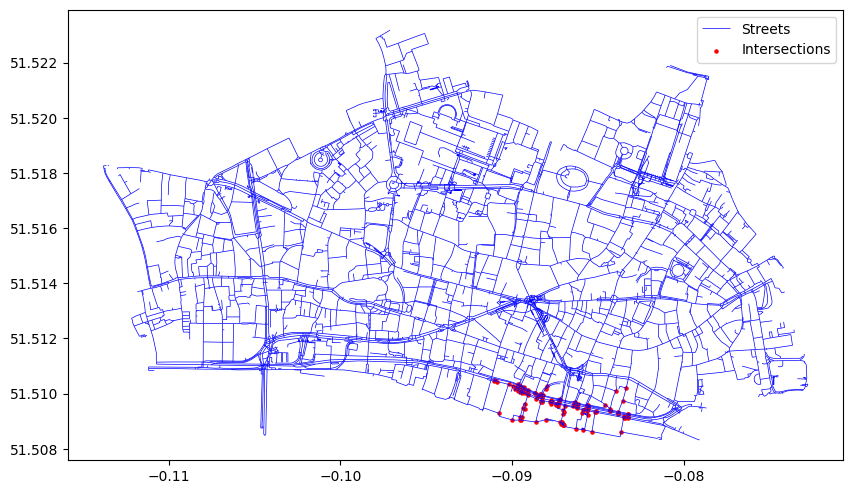

In [26]:
fig, ax = plt.subplots(figsize=(10, 10))
streets.plot(ax=ax, color='blue', linewidth=0.5, label='Streets')
intersection_gdf_unique.plot(ax=ax, color='red', marker='o', markersize=5, label='Intersections')

plt.legend()
plt.show()

In [33]:
import geopandas as gpd
from shapely.geometry import LineString, Point
from shapely.ops import split

# Load the streets data if not already loaded
streets = gpd.read_file('London_UK/network/edges/edges.geojson')

# Ensure intersection points are unique
intersection_points = intersection_gdf_unique['geometry'][:200].unique()

# Function to split a line at given points
def split_line_at_points(line, points):
    # Sort points along the line
    points = sorted(points, key=lambda point: line.project(point))
    # Split the line at each point
    segments = []
    for point in points:
        # Split the line at the point
        split_result = split(line, point)
        # Add the segments to the list
        segments.extend(split_result.geoms)
    return segments

# List to store the split lines
split_lines = []

# Iterate over each line in the streets GeoDataFrame
for line in streets['geometry'][:200]:
    # Find intersection points that lie on the current line
    line_points = [point for point in intersection_points if line.intersects(point)]
    if line_points:
        # Split the line at these points
        split_segments = split_line_at_points(line, line_points)
        split_lines.extend(split_segments)
    else:
        # If no intersection points, add the line as is
        split_lines.append(line)

# Create a new GeoDataFrame with the split lines
split_streets_gdf = gpd.GeoDataFrame(geometry=split_lines, crs=streets.crs)

# Display the result
print(split_streets_gdf)

                                              geometry
0    LINESTRING (-0.08366 51.50861, -0.08371 51.508...
1    LINESTRING (-0.08366 51.50861, -0.08371 51.508...
2     LINESTRING (-0.08589 51.5087, -0.08535 51.50862)
3     LINESTRING (-0.08589 51.5087, -0.08535 51.50862)
4    LINESTRING (-0.08589 51.5087, -0.08623 51.5087...
..                                                 ...
363  LINESTRING (-0.09102 51.51049, -0.0909 51.5104...
364  LINESTRING (-0.09102 51.51049, -0.0909 51.5104...
365  LINESTRING (-0.09102 51.51049, -0.09105 51.51044)
366  LINESTRING (-0.09102 51.51049, -0.09105 51.51044)
367  LINESTRING (-0.09118 51.51061, -0.09111 51.510...

[368 rows x 1 columns]


In [34]:
if split_streets_gdf.crs.is_geographic:
    split_streets_gdf = split_streets_gdf.to_crs(epsg=27700)

# Calculate the length of each LineString
split_streets_gdf['length'] = split_streets_gdf.length

# Display the result
print(split_streets_gdf[['geometry', 'length']])

                                              geometry      length
0    LINESTRING (533088.395 180594.243, 533085.231 ...  135.904422
1    LINESTRING (533088.395 180594.243, 533085.231 ...  135.904422
2    LINESTRING (532933.586 180599.517, 532971.003 ...   38.068525
3    LINESTRING (532933.586 180599.517, 532971.003 ...   38.068525
4    LINESTRING (532933.586 180599.517, 532909.46 1...   27.608691
..                                                 ...         ...
363  LINESTRING (532571.864 180789.369, 532580.291 ...   12.723334
364  LINESTRING (532571.864 180789.369, 532580.291 ...   12.723334
365  LINESTRING (532571.864 180789.369, 532570.369 ...    5.209887
366  LINESTRING (532571.864 180789.369, 532570.369 ...    5.209887
367  LINESTRING (532560.449 180803.193, 532565.746 ...  111.481602

[368 rows x 2 columns]


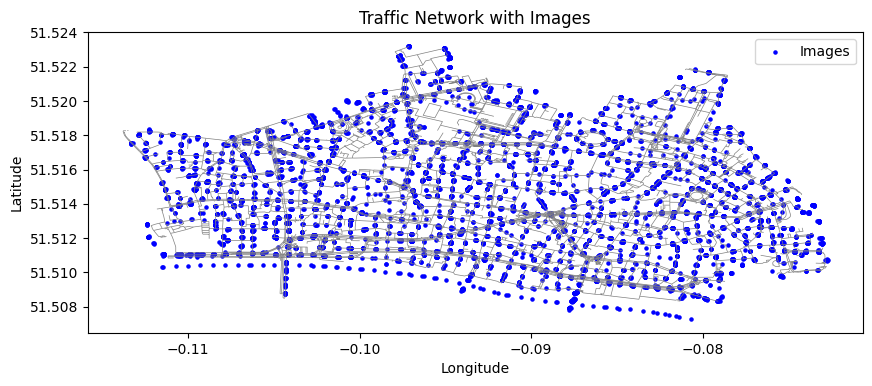

In [35]:
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd
import matplotlib.pyplot as plt

# Load street network data
# streets = gpd.read_file('streets.geojson')  # Replace with your data source

# Assuming panoids DataFrame has columns 'panoid', 'lng', and 'lat'
# Example:
# panoids = pd.DataFrame({
#     'panoid': ['id1', 'id2', 'id3', ...],
#     'lng': [-0.10543, -0.0949, -0.10601, ...],
#     'lat': [51.51575, 51.51736, 51.51575, ...]
# })

# Create a DataFrame with image IDs and their corresponding GPS coordinates
image_data = {
    'image_id': np.arange(len(panoids)),
    'panoid': panoids.panoid,
    'longitude': panoids.lng,
    'latitude': panoids.lat,
}
images_df = pd.DataFrame(image_data)

# Create GeoDataFrame for images
geometry = [Point(xy) for xy in zip(images_df['longitude'], images_df['latitude'])]
images_gdf = gpd.GeoDataFrame(images_df, geometry=geometry, crs=27700)

# Perform Spatial Join to find nearest street for each image
matched = gpd.sjoin_nearest(images_gdf, split_streets_gdf, how='left', distance_col='distance')
# Function to get coordinates by image ID
def get_coords_by_image_id(image_id):
    row = matched[matched['image_id'] == image_id]
    if not row.empty:
        return row['geometry'].values[0].x, row['geometry'].values[0].y
    else:
        return None, None

# Visualize the traffic network with images
fig, ax = plt.subplots(figsize=(10, 10))
streets.plot(ax=ax, color='gray', linewidth=0.5)
images_gdf.plot(ax=ax, color='blue', markersize=5, label='Images')

# Add labels and legend
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Traffic Network with Images')
plt.legend()

plt.show()

c:\Users\lucia\anaconda3\envs\dsaie\lib\site-packages\geopandas\array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


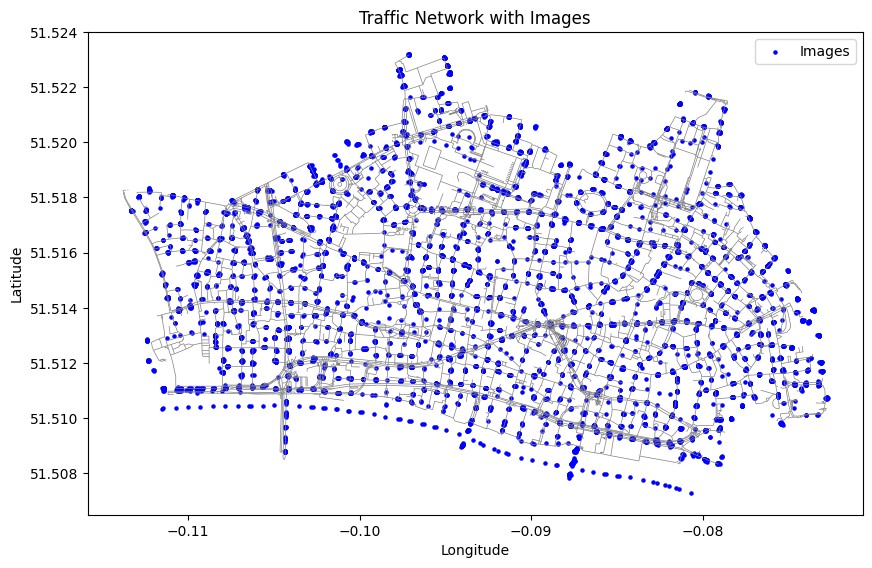

In [36]:
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load street network data
# streets = gpd.read_file('streets.geojson')  # Replace with your data source

# Assuming panoids DataFrame has columns 'panoid', 'lng', and 'lat'
# Example:
# panoids = pd.DataFrame({
#     'panoid': ['id1', 'id2', 'id3'],
#     'lng': [-0.10543, -0.0949, -0.10601],
#     'lat': [51.51575, 51.51736, 51.51575]
# })

# Create a DataFrame with image IDs and their corresponding GPS coordinates
image_data = {
    'image_id': np.arange(len(panoids)),
    'panoid': panoids.panoid,
    'longitude': panoids.lng,
    'latitude': panoids.lat,
}
images_df = pd.DataFrame(image_data)

# Create GeoDataFrame for images
geometry = [Point(xy) for xy in zip(images_df['longitude'], images_df['latitude'])]


images_gdf = gpd.GeoDataFrame(images_df, geometry=geometry, crs=streets.crs)

# Ensure merged_streets_gdf is in the same CRS as images_gdf
merged_streets_gdf = merged_streets_gdf.to_crs(images_gdf.crs)

# Perform Spatial Join to find nearest street for each image
matched = gpd.sjoin_nearest(images_gdf, merged_streets_gdf, how='left', distance_col='distance')

# Function to get coordinates by image ID
def get_coords_by_image_id(image_id):
    row = matched[matched['image_id'] == image_id]
    if not row.empty:
        return row['geometry'].values[0].x, row['geometry'].values[0].y
    else:
        return None, None

# Visualize the traffic network with images
fig, ax = plt.subplots(figsize=(10, 10))
streets.plot(ax=ax, color='gray', linewidth=0.5)
images_gdf.plot(ax=ax, color='blue', markersize=5, label='Images')

# Add labels and legend
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Traffic Network with Images')
plt.legend()
plt.show()

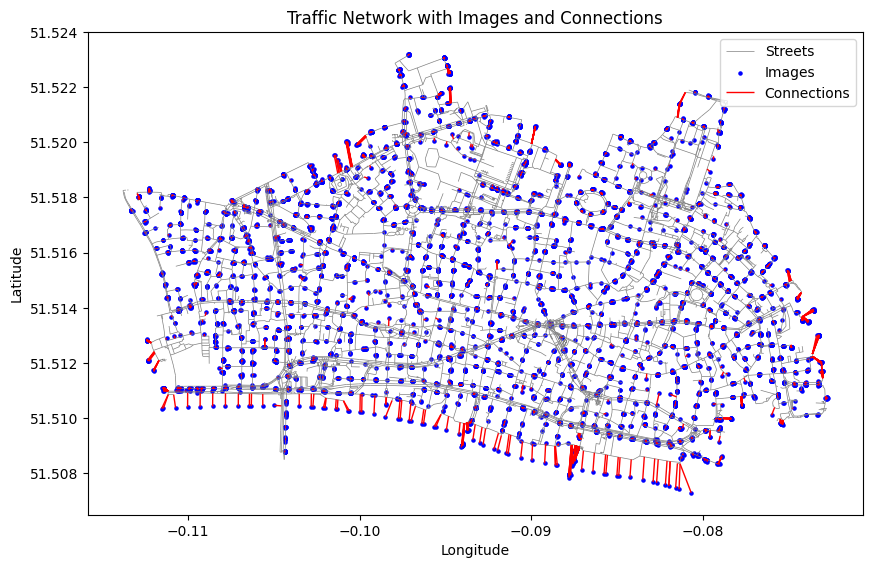

In [37]:
# Create lines connecting images to their nearest street
connecting_lines = []
for idx, row in matched.iterrows():
    image_point = row['geometry']
    nearest_line_index = row['index_right']  # This is the index of the nearest line
    nearest_line = merged_streets_gdf.loc[nearest_line_index, 'geometry']  # Get the actual LineString
    connecting_line = LineString([image_point, nearest_line.interpolate(nearest_line.project(image_point))])
    connecting_lines.append(connecting_line)

# Create a GeoDataFrame for the connecting lines
connecting_lines_gdf = gpd.GeoDataFrame(geometry=connecting_lines, crs=merged_streets_gdf.crs)

# Visualize the traffic network with images and connecting lines
fig, ax = plt.subplots(figsize=(10, 10))
merged_streets_gdf.plot(ax=ax, color='gray', linewidth=0.5, label='Streets')
images_gdf.plot(ax=ax, color='blue', markersize=5, label='Images')
connecting_lines_gdf.plot(ax=ax, color='red', linewidth=1, label='Connections')

# Add labels and legend
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Traffic Network with Images and Connections')
plt.legend()
plt.show()

c:\Users\lucia\anaconda3\envs\dsaie\lib\site-packages\geopandas\array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


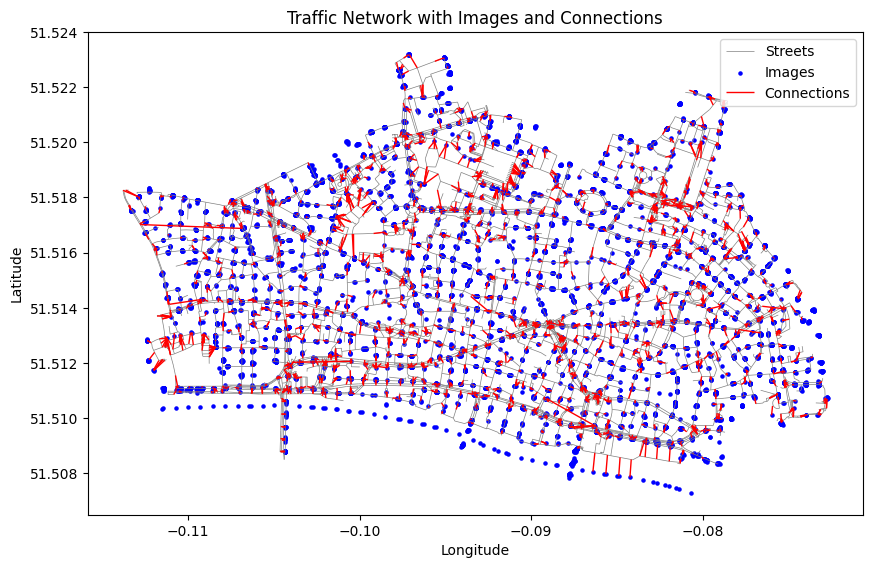

In [39]:
import geopandas as gpd
from shapely.geometry import Point, LineString
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming panoids DataFrame has columns 'panoid', 'lng', and 'lat'
# Example:
# panoids = pd.DataFrame({
#     'panoid': ['id1', 'id2', 'id3'],
#     'lng': [-0.10543, -0.0949, -0.10601],
#     'lat': [51.51575, 51.51736, 51.51575]
# })

# Create a DataFrame with image IDs and their corresponding GPS coordinates
image_data = {
    'image_id': np.arange(len(panoids)),
    'panoid': panoids.panoid,
    'longitude': panoids.lng,
    'latitude': panoids.lat,
}
images_df = pd.DataFrame(image_data)

# Create GeoDataFrame for images
geometry = [Point(xy) for xy in zip(images_df['longitude'], images_df['latitude'])]
images_gdf = gpd.GeoDataFrame(images_df, geometry=geometry, crs=streets.crs)

# Ensure merged_streets_gdf is in the same CRS as images_gdf
merged_streets_gdf = merged_streets_gdf.to_crs(images_gdf.crs)

# Perform Spatial Join to find nearest image for each street segment
matched = gpd.sjoin_nearest(merged_streets_gdf, images_gdf, how='left', distance_col='distance')

# Create lines connecting each street segment to its nearest image
connecting_lines = []
for idx, row in matched.iterrows():
    line_segment = row['geometry']
    nearest_image_index = row['index_right']  # This is the index of the nearest image
    nearest_image_point = images_gdf.loc[nearest_image_index, 'geometry']  # Get the actual Point
    connecting_line = LineString([line_segment.interpolate(line_segment.project(nearest_image_point)), nearest_image_point])
    connecting_lines.append(connecting_line)

# Create a GeoDataFrame for the connecting lines
connecting_lines_gdf = gpd.GeoDataFrame(geometry=connecting_lines, crs=merged_streets_gdf.crs)

# Visualize the traffic network with images and connecting lines
fig, ax = plt.subplots(figsize=(10, 10))
merged_streets_gdf.plot(ax=ax, color='gray', linewidth=0.5, label='Streets')
images_gdf.plot(ax=ax, color='blue', markersize=5, label='Images')
connecting_lines_gdf.plot(ax=ax, color='red', linewidth=1, label='Connections')

# Add labels and legend
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Traffic Network with Images and Connections')
plt.legend()
plt.show()